# Toy model for estimation of connectivity in MOU process

This Python notebook estimates the connectivity matrix from the observed activity generated by a MOU process.

In [10]:
import os
import numpy as np
import scipy.linalg as spl
import scipy.stats as stt
import scipy.signal as sgn
from pyMOU.MOU_model_Testing_Correlation import MOU
import pyMOU.tools as tools
import matplotlib.pyplot as pp

import scipy.io as io

In [11]:
#Defining data loaders and data merger that will be used later on
def load_average(path, file_name, ending, subject_list):

    # Get and save common sources across all subjects
    print('Loading common sources and average signals...')
    
    try:
        
        common_sources = np.load('_common_sources.npy')
        average_signals = np.load('_average_signals.npy')

    except IOError:

        for subject_number in subject_list:
            file = io.loadmat(path + file_name + str(subject_number) + ending)
            if not np.isnan(file['ic_data3']).any():
                if(subject_number != subject_list[0]):
                    previous_common_sources = common_sources
                    common_sources = file['listD']
                    common_sources = np.intersect1d(common_sources, previous_common_sources, assume_unique=True)  
                    
                    average_signals[np.where(common_sources)[0],:,:,:] += file['ic_data3'][np.where(common_sources)[0],:,:,:].astype('complex128')  

                else:
                    common_sources = file['listD']
                    
                    average_signals = file['ic_data3'][:,:,:,:].astype('complex128')
            else:
                print('WRONG SUBJECT', subject_number)


            print('Current subject:',subject_number)
            print('Current common sources:',common_sources)

        
        with open('_common_sources.npy','wb') as f:
            np.save(f, common_sources)

        with open('_average_signals.npy','wb') as f:
            np.save(f, average_signals[np.where(common_sources)[0],:,:,:] / len(subject_list))

        common_sources = np.load('_common_sources.npy')
        average_signals = np.load('_average_signals.npy')
        
        
    finally:
        
        print('Common sources and average signals loaded')
        return(common_sources, average_signals)
        
def load_single(path, file_name, ending, subject_number):
    
    print("Loading subject's sources and signals...")
    file = io.loadmat(path + file_name + str(subject_number) + ending)

    print("Subject's sources and signals loaded")
    return(file['listD'], file['ic_data3'][:,:,:,:])

def merge_sessions_types_and_trials(ts, motivation):
    ts_tmp = np.swapaxes(ts,0,1)
    if motivation == 'SF':
        ts_sim = np.zeros((ts_tmp.shape[0],ts_tmp.shape[1],2), dtype='complex128')
        
        for i in range(2):
            ts_sim[:,:,0] += np.mean(ts_tmp[:, :, :, i*6], axis=2)/4
            ts_sim[:,:,0] += np.mean(ts_tmp[:, :, :, i*6 + 1], axis=2)/4
            ts_sim[:,:,1] += np.mean(ts_tmp[:, :, :, i*6 + 2], axis=2)/8
            ts_sim[:,:,1] += np.mean(ts_tmp[:, :, :, i*6 + 3], axis=2)/8
            ts_sim[:,:,1] += np.mean(ts_tmp[:, :, :, i*6 + 4], axis=2)/8
            ts_sim[:,:,1] += np.mean(ts_tmp[:, :, :, i*6 + 5], axis=2)/8
    else:
        ts_sim = np.zeros((ts_tmp.shape[0], ts_tmp.shape[1], 2), dtype='complex128')
        for i in range(2):
            ts_sim[:,:,0] += np.mean(ts_tmp[:, :, :, i*6 + 2], axis=2)/4
            ts_sim[:,:,0] += np.mean(ts_tmp[:, :, :, i*6 + 3], axis=2)/4
            ts_sim[:,:,1] += np.mean(ts_tmp[:, :, :, i*6 + 4], axis=2)/4
            ts_sim[:,:,1] += np.mean(ts_tmp[:, :, :, i*6 + 5], axis=2)/4
    
    return ts_sim

def filtering(ts_sim, band):
    
    #Filtering by gamma frequency = [40-80Hz] or betta frequency = [15,32] at frequency sample = 500Hz
    if band == 'G':
        sos = sgn.butter(10, [40,80], 'bp', fs=500, output='sos')
    elif band == 'B':
        sos = sgn.butter(10, [15,32], 'bp', fs=500, output='sos')
    elif band == 'A':
        sos = sgn.butter(10, [8,12], 'bp', fs=500, output='sos')
    
    return sgn.sosfilt(sos, ts_sim)

def cohens_d(x, y):
    S_corr = (len(x) - 1)*np.var(x,ddof=1) + (len(y) - 1)*np.var(y,ddof=1)
    S_corr /= (len(x) - 1 + len(y) - 1)
    S_corr = S_corr**0.5

    cohen_d_corr = np.abs(np.mean(x) - np.mean(y)) / S_corr
    return cohen_d_corr
    

## Simulation

In [12]:
# LOADING DATA

path = '../eeg/pacients_sans/EEG-BCN/'
file_name = 'dataClean-ICA3-'
ending = '-T1.mat'
subject_list = np.arange(25,36)
subject_number = 25

common_sources, average_signals = load_average(path, file_name, ending, subject_list)
sources, signals = load_single(path, file_name, ending, subject_number)

# FILTERING BY BAND

band = 'G' #G for gamma, B for betta
ts_sim = average_signals
ts_sim_subject = signals[np.where(common_sources)[0],:,:,:]
    
filtered = filtering(ts_sim, band)
filtered_subject = filtering(ts_sim_subject, band)


Loading common sources and average signals...
Common sources and average signals loaded
Loading subject's sources and signals...
Subject's sources and signals loaded


c:\Users\albas\miniconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\albas\miniconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


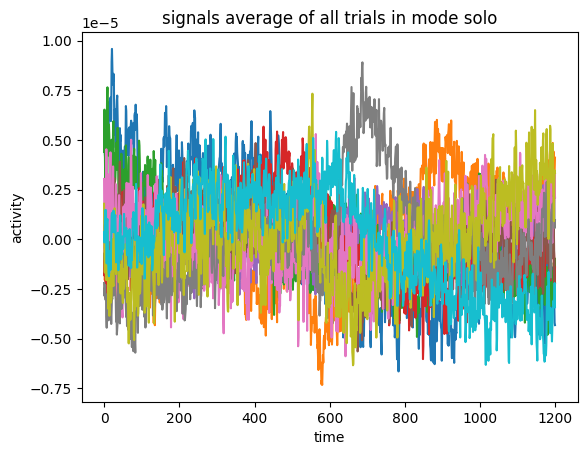

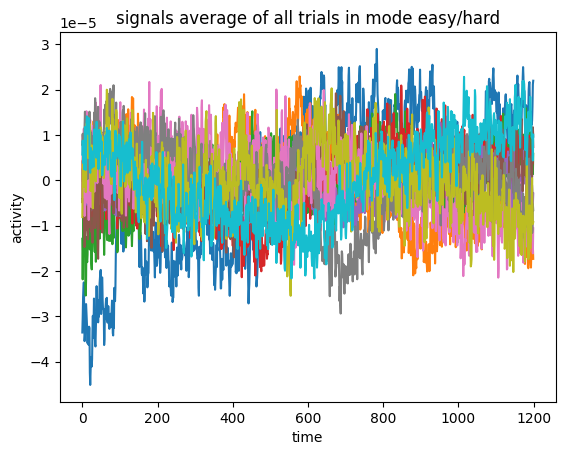

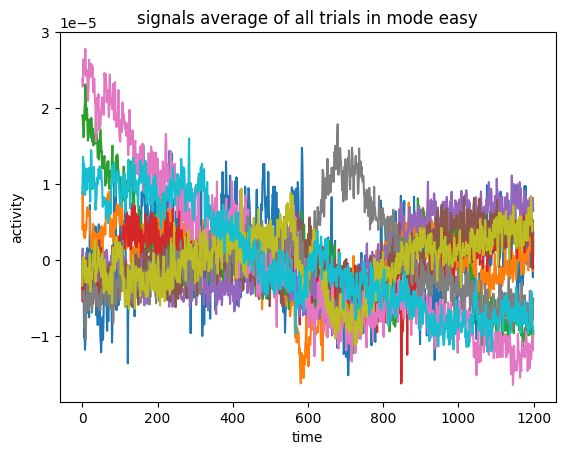

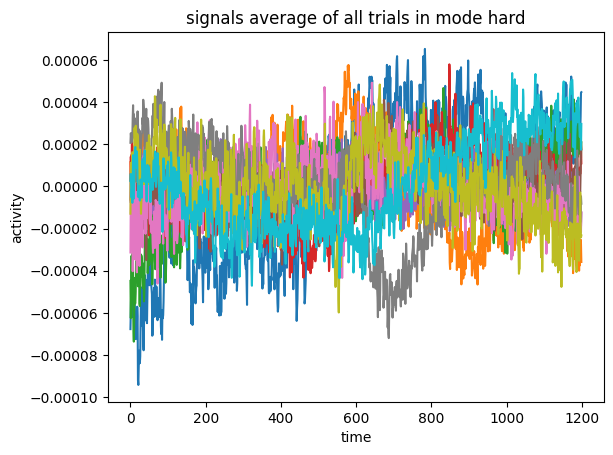

In [13]:
# MERGING DATA FROM SESSIONS, TYPE OF ACTION AND TRIAL
ts_sim_motiv = list()
ts_sim_motiv_subject = list()
text_dict = {'SF': ['mode solo', 'mode easy/hard'], 'SP': ['mode easy', 'mode hard']}
variables = ['SF', 'SP']
for variable in variables:
    ts_sim = merge_sessions_types_and_trials(filtered, variable)
    ts_sim_subject = merge_sessions_types_and_trials(filtered_subject, variable)
    ts_sim_motiv.append(ts_sim)
    ts_sim_motiv_subject.append(ts_sim_subject)

    pp.figure()
    pp.plot(range(ts_sim.shape[0]),ts_sim[:,:,0])
    pp.xlabel('time')
    pp.ylabel('activity')
    pp.title('signals average of all trials in ' + text_dict[variable][0])

    pp.figure()
    pp.plot(range(ts_sim.shape[0]),ts_sim[:,:,1])
    pp.xlabel('time')
    pp.ylabel('activity')
    pp.title('signals average of all trials in ' + text_dict[variable][1])

    pp.show()

SF


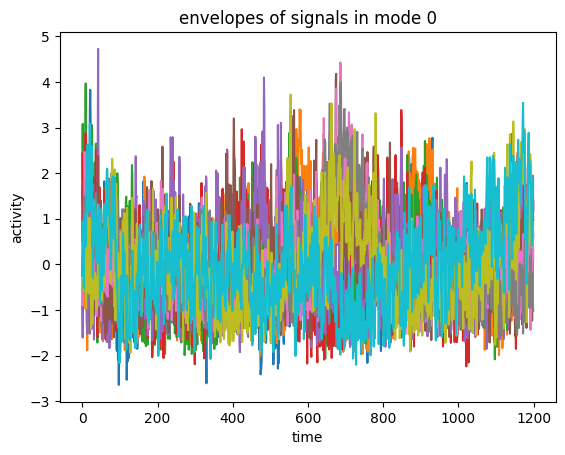

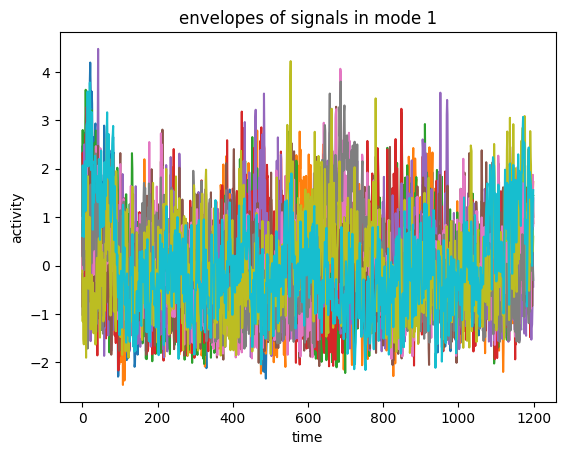

SP


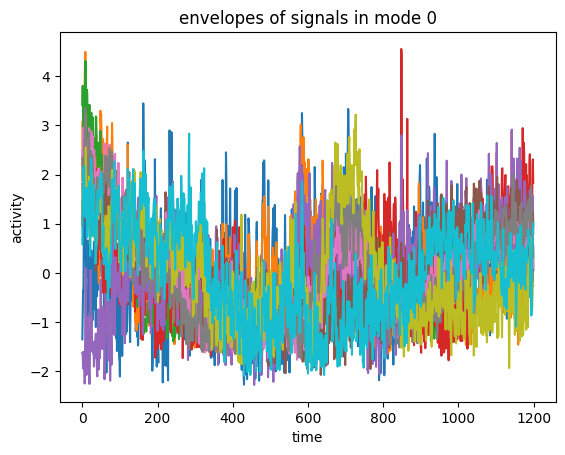

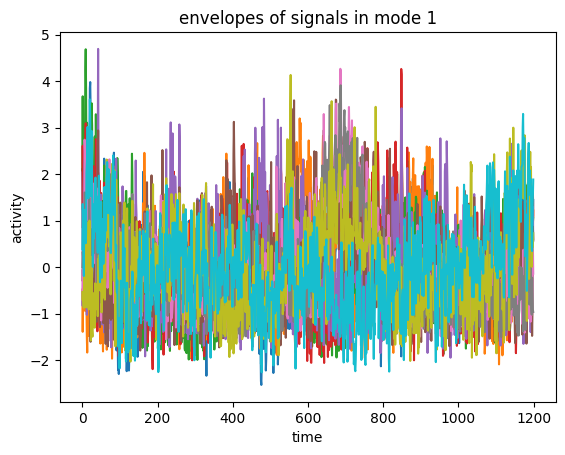

In [14]:
# ENVELOPING AND NORMALIZATION

ts_sim_0_motiv = list()
ts_sim_1_motiv = list()
ts_sim_0_motiv_subject = list()
ts_sim_1_motiv_subject = list()

for i,ts_sim in enumerate(ts_sim_motiv):

    # Procés per un subjecte concret
    ts_sim_subject = ts_sim_motiv_subject[i]
    envelope_subject = np.zeros([ts_sim_subject.shape[0], ts_sim_subject.shape[1]])
    envelope_subject = sgn.hilbert(ts_sim_subject[:, :, 0].real)
    ts_sim_0_subject = np.abs(envelope_subject)

    envelope_subject = sgn.hilbert(ts_sim_subject[:, :, 1].real)
    ts_sim_1_subject = np.abs(envelope_subject)

    for source in range(ts_sim_subject.shape[1]):
        ts_sim_0_subject[:, source] = (ts_sim_0_subject[:, source] - np.mean(ts_sim_0_subject[:, source])) / np.std(ts_sim_0_subject[:, source])
        ts_sim_1_subject[:, source] = (ts_sim_1_subject[:, source] - np.mean(ts_sim_1_subject[:, source])) / np.std(ts_sim_1_subject[:, source])

    ts_sim_0_motiv_subject.append(ts_sim_0_subject)
    ts_sim_1_motiv_subject.append(ts_sim_1_subject)
    
    # Procés per la mitjana de subjectes
    envelope = np.zeros([ts_sim.shape[0],ts_sim.shape[1]])

    envelope = sgn.hilbert(ts_sim[:,:,0].real)

    ts_sim_0 = np.abs(envelope)

    envelope = sgn.hilbert(ts_sim[:,:,1].real)

    ts_sim_1 = np.abs(envelope)

    for source in range(ts_sim.shape[1]):
        ts_sim_0[:,source] = (ts_sim_0[:,source] - np.mean(ts_sim_0[:,source]))/np.std(ts_sim_0[:,source])
        ts_sim_1[:,source] = (ts_sim_1[:,source] - np.mean(ts_sim_1[:,source]))/np.std(ts_sim_1[:,source])

    ts_sim_0_motiv.append(ts_sim_0)
    ts_sim_1_motiv.append(ts_sim_1)

    print(variables[i])
    pp.figure()
    pp.plot(range(0,ts_sim.shape[0]),ts_sim_0)
    pp.xlabel('time')
    pp.ylabel('activity')
    pp.title('envelopes of signals in mode 0')

    pp.figure()
    pp.plot(range(0,ts_sim.shape[0]),ts_sim_1)
    pp.xlabel('time')
    pp.ylabel('activity')
    pp.title('envelopes of signals in mode 1')

    pp.show()

## Connectivity estimation

SF


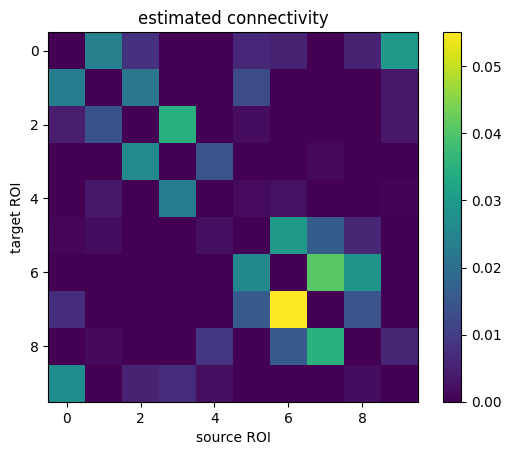

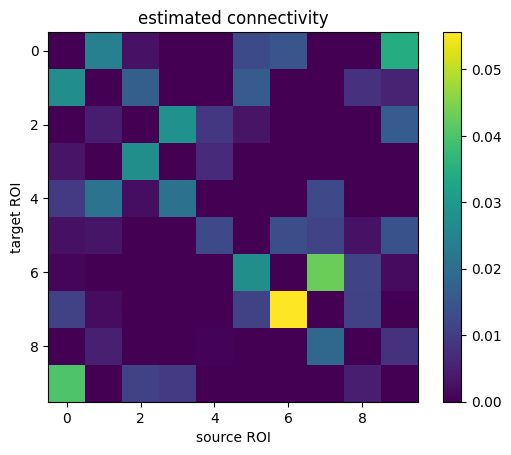

Optimization did not converge. Maximum number of iterations arrived.
SP


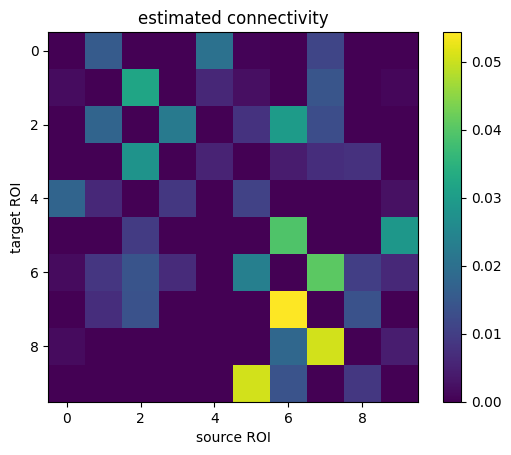

Optimization did not converge. Maximum number of iterations arrived.


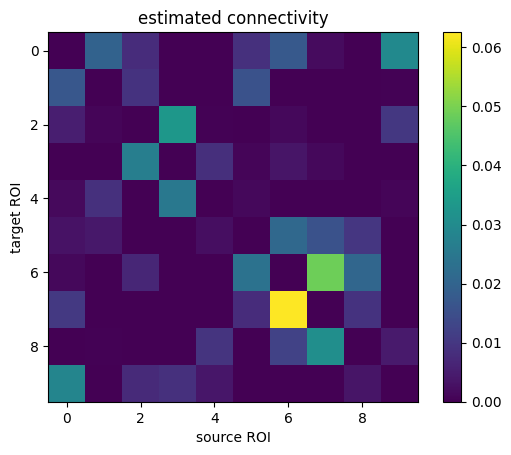

In [15]:
# Lyapunov optimization
mou_est_0_motiv = list()
c_est_0_motiv = list()
mou_est_1_motiv = list()
c_est_1_motiv = list()

mou_est_0_motiv_subject = list()
c_est_0_motiv_subject = list()
mou_est_1_motiv_subject = list()
c_est_1_motiv_subject = list()

for motiv in range (2):
    ts_sim_0 = ts_sim_0_motiv[motiv]
    ts_sim_1 = ts_sim_1_motiv[motiv]
    # motivation state 0
    mou_est_0 = MOU()
    mou_est_0.fit(ts_sim_0, regul_C=1., i_tau_opt=15)
    C_est_0 = mou_est_0.get_C()

    mou_est_0_motiv.append(mou_est_0)
    c_est_0_motiv.append(C_est_0)

    print(variables[motiv])
    pp.figure()
    pp.imshow(C_est_0,vmin=0)
    pp.colorbar()
    pp.xlabel('source ROI')
    pp.ylabel('target ROI')
    pp.title('estimated connectivity')

    pp.show()

    # motivation stat 1
    mou_est_1 = MOU()
    mou_est_1.fit(ts_sim_1, regul_C=1., i_tau_opt=15)

    C_est_1 = mou_est_1.get_C()

    mou_est_1_motiv.append(mou_est_1)
    c_est_1_motiv.append(C_est_1)

    pp.figure()
    pp.imshow(C_est_1,vmin=0)
    pp.colorbar()
    pp.xlabel('source ROI')
    pp.ylabel('target ROI')
    pp.title('estimated connectivity')

    pp.show()

    # Processament per a les dades del subjecte
    ts_sim_0_subject = ts_sim_0_motiv_subject[motiv]
    ts_sim_1_subject = ts_sim_1_motiv_subject[motiv]

    # motivation state 0 (subject)
    mou_est_0_subject = MOU()
    mou_est_0_subject.fit(ts_sim_0_subject, regul_C=1., i_tau_opt=15)
    C_est_0_subject = mou_est_0_subject.get_C()

    mou_est_0_motiv_subject.append(mou_est_0_subject)
    c_est_0_motiv_subject.append(C_est_0_subject)

    # motivation state 1 (subject)
    mou_est_1_subject = MOU()
    mou_est_1_subject.fit(ts_sim_1_subject, regul_C=1., i_tau_opt=15)
    C_est_1_subject = mou_est_1_subject.get_C()

    mou_est_1_motiv_subject.append(mou_est_1_subject)
    c_est_1_motiv_subject.append(C_est_1_subject)

In [16]:
for motiv in range (2):
    mou_est_0 = mou_est_0_motiv[motiv]
    C_est_0 = c_est_0_motiv[motiv]
    mou_est_1 = mou_est_1_motiv[motiv]
    C_est_1 = c_est_1_motiv[motiv]
    print('MOTIVATION STATE:', motiv)
    print('model fit', text_dict[variables[motiv]][0], 'mode:',mou_est_0.d_fit['correlation'])
    print('model fit', text_dict[variables[motiv]][1], 'mode:',mou_est_1.d_fit['correlation'])
    print("\n")
    print('Norma de C', text_dict[variables[motiv]][0], 'mode:',spl.norm(C_est_0))
    print('Norma de C', text_dict[variables[motiv]][0], 'mode:',spl.norm(C_est_1))
    print("\n")
    print('Tau', text_dict[variables[motiv]][0], 'mode:',mou_est_0.get_tau_x())
    print('Tau', text_dict[variables[motiv]][0], 'mode:',mou_est_1.get_tau_x())
    print("\n")
    print('Sigma', text_dict[variables[motiv]][0], 'mode:',mou_est_0.Sigma)
    print('Sigma', text_dict[variables[motiv]][0], 'mode:',mou_est_1.Sigma)

MOTIVATION STATE: 0
model fit mode solo mode: 0.9219697173931911
model fit mode easy/hard mode: 0.8982540034943121


Norma de C mode solo mode: 0.12646893704997017
Norma de C mode solo mode: 0.12572102651920483


Tau mode solo mode: [8.35552098 8.35552098 8.35552098 8.35552098 8.35552098 8.35552098
 8.35552098 8.35552098 8.35552098 8.35552098]
Tau mode solo mode: [8.22887957 8.22887957 8.22887957 8.22887957 8.22887957 8.22887957
 8.22887957 8.22887957 8.22887957 8.22887957]


Sigma mode solo mode: [[0.19785726 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.21481986 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.20281615 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.20557738 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.22026784 0.
  0.     

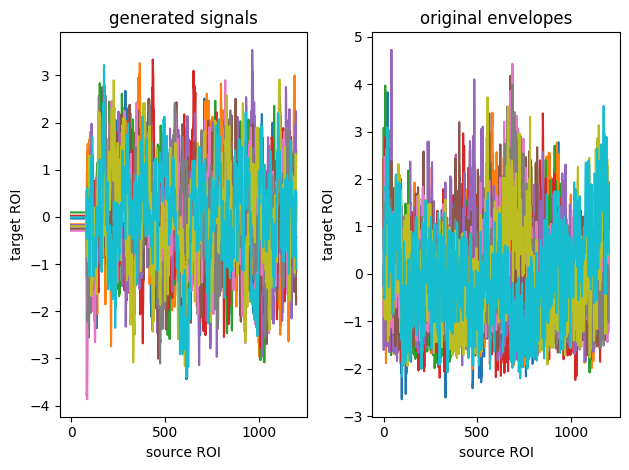

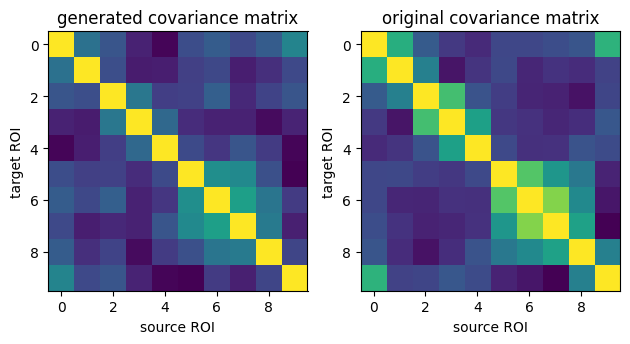

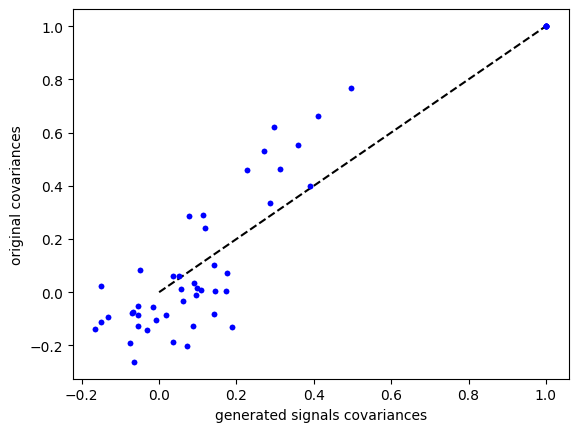

Covariance fit for covariances PearsonRResult(statistic=np.float64(0.9197289824652843), pvalue=np.float64(1.3896563189120085e-41))
Cohen's d using correlation 0.015216234802106536
Z-score of generated covariances [ 2.63515878  0.28918082 -0.1191398  -0.75374834 -1.05938356 -0.22578029
 -0.02276943 -0.28732429 -0.0177787   0.57521401  0.28918082  2.63515878
 -0.21157237 -0.81948788 -0.79103197 -0.39154887 -0.29648658 -0.79804564
 -0.60413641 -0.27515734 -0.1191398  -0.21157237  2.63515878  0.37877988
 -0.40918189 -0.37828122  0.02642296 -0.68111703 -0.34951162 -0.11629274
 -0.75374834 -0.81948788  0.37877988  2.63515878  0.15128933 -0.63145137
 -0.75509744 -0.75430583 -1.00025444 -0.73700726 -1.05938356 -0.79103197
 -0.40918189  0.15128933  2.63515878 -0.26321302 -0.51853219 -0.12151185
 -0.45843188 -1.05859382 -0.22578029 -0.39154887 -0.37828122 -0.63145137
 -0.26321302  2.63515878  0.74253547  0.670979   -0.19960354 -1.10653185
 -0.02276943 -0.29648658  0.02642296 -0.75509744 -0.51853

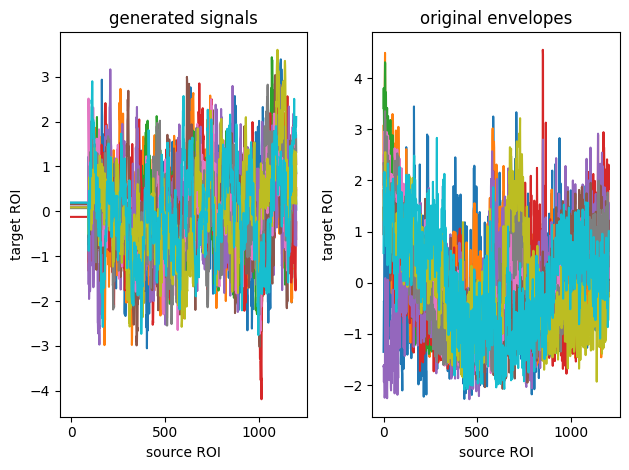

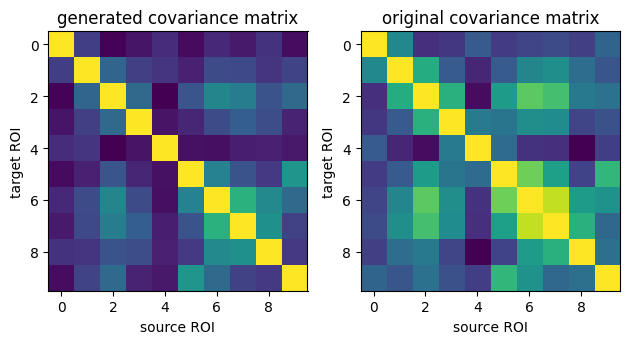

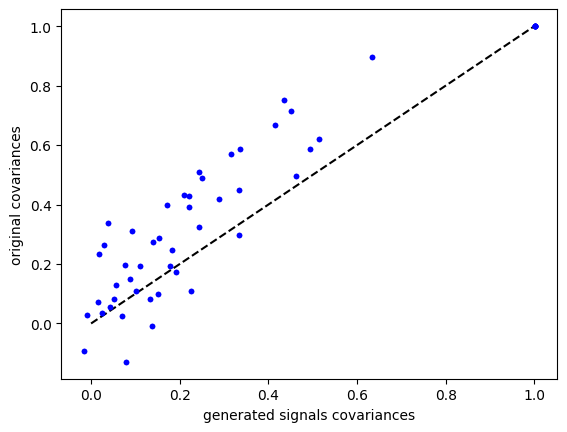

Covariance fit for covariances PearsonRResult(statistic=np.float64(0.9130025414242937), pvalue=np.float64(6.078099357236382e-40))
Cohen's d using correlation 0.3072425405040946
Z-score of generated covariances [ 2.55166308 -0.38208507 -1.01357207 -0.83469304 -0.59242468 -0.93187669
 -0.63072618 -0.78427955 -0.51535725 -0.92214115 -0.38208507  2.55166308
  0.13239183 -0.3557438  -0.50330124 -0.71159401 -0.20379456 -0.24586352
 -0.4884566  -0.3061352  -1.01357207  0.13239183  2.55166308  0.20587904
 -1.04287324 -0.10025003  0.6068447   0.48422506 -0.12287783  0.19599146
 -0.83469304 -0.3557438   0.20587904  2.55166308 -0.84875741 -0.65510442
 -0.20393283  0.03459689 -0.18854382 -0.67850114 -0.59242468 -0.50330124
 -1.04287324 -0.84875741  2.55166308 -0.88444533 -0.89909789 -0.73557777
 -0.70612394 -0.80364143 -0.93187669 -0.71159401 -0.10025003 -0.65510442
 -0.88444533  2.55166308  0.55179    -0.1282391  -0.45255827  0.83032013
 -0.63072618 -0.20379456  0.6068447  -0.20393283 -0.89909789

In [17]:
# RESULTS FOR STATE 0 MODE WITH RANDOM INITIAL CONDITION
for motiv in range (2):
    mou_est_0 = mou_est_0_motiv[motiv]
    C_est_0 = c_est_0_motiv[motiv]
    mou_est_1 = mou_est_1_motiv[motiv]
    C_est_1 = c_est_1_motiv[motiv]

    ts_sim = ts_sim_motiv[motiv]
    ts_sim_0 = ts_sim_0_motiv[motiv]
    ts_sim_1 = ts_sim_1_motiv[motiv]

    ts_generated_rand_IC = mou_est_0.simulate(T=ts_sim.shape[0], dt=0.002)

    for i in range(ts_generated_rand_IC.shape[1]):
        ts_generated_rand_IC[:,i] = (ts_generated_rand_IC[:,i] - np.mean(ts_generated_rand_IC[:,i])) / np.std(ts_generated_rand_IC[:,i])

    fig, (ax_gen, ax_orig) = pp.subplots(1,2)
    ax_gen.plot(range(ts_generated_rand_IC.shape[0]),ts_generated_rand_IC)
    ax_gen.set_xlabel('source ROI')
    ax_gen.set_ylabel('target ROI')
    ax_gen.set_title('generated signals')

    ax_orig.plot(range(ts_sim.shape[0]),ts_sim_0)
    ax_orig.set_xlabel('source ROI')
    ax_orig.set_ylabel('target ROI')
    ax_orig.set_title('original envelopes')
    pp.tight_layout()

    pp.show()

    #Covariances of signals from simulate
    Q_generated_rand_IC = np.tensordot(ts_generated_rand_IC,ts_generated_rand_IC,axes=(0,0)) / (ts_generated_rand_IC.shape[0]-1)

    #Covariances of envelopes of original signals
    Q_th = np.tensordot(ts_sim_0,ts_sim_0,axes=(0,0)) / (ts_sim.shape[0]-1)

    # plots
    fig, (ax_gen, ax_orig) = pp.subplots(1,2)
    ax_gen.imshow(Q_generated_rand_IC)
    ax_gen.set_xlabel('source ROI')
    ax_gen.set_ylabel('target ROI')
    ax_gen.set_title('generated covariance matrix')

    ax_orig.imshow(Q_th)
    ax_orig.set_xlabel('source ROI')
    ax_orig.set_ylabel('target ROI')
    ax_orig.set_title('original covariance matrix')
    pp.tight_layout()

    pp.figure()
    pp.plot([0,Q_generated_rand_IC.max()],[0,Q_th.max()],'--k')
    pp.plot(Q_generated_rand_IC,Q_th,'.b')
    pp.xlabel('generated signals covariances')
    pp.ylabel('original covariances')

    pp.show()

    print('Covariance fit for covariances',stt.pearsonr(Q_th.flatten(),Q_generated_rand_IC.flatten()))
    print("Cohen's d using correlation", cohens_d(Q_th.flatten(),Q_generated_rand_IC.flatten()))

    #print('z-score of empirical covariances',stt.zscore(Q_th.flatten()))
    print('Z-score of generated covariances',stt.zscore(Q_generated_rand_IC.flatten()))
    print('Mean of differences in z-scores',np.mean(np.abs(stt.zscore((Q_th.flatten() - Q_generated_rand_IC.flatten())))))

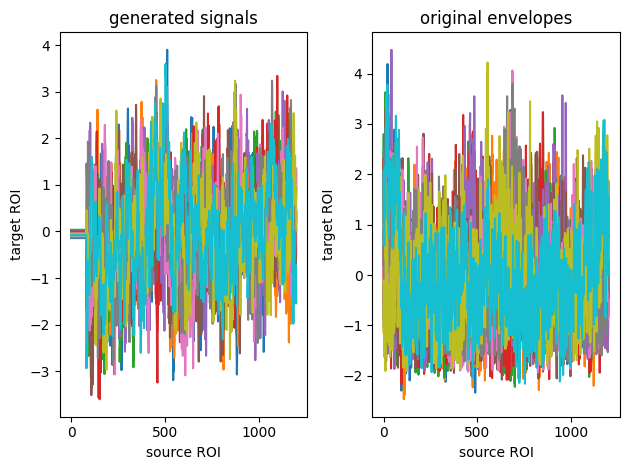

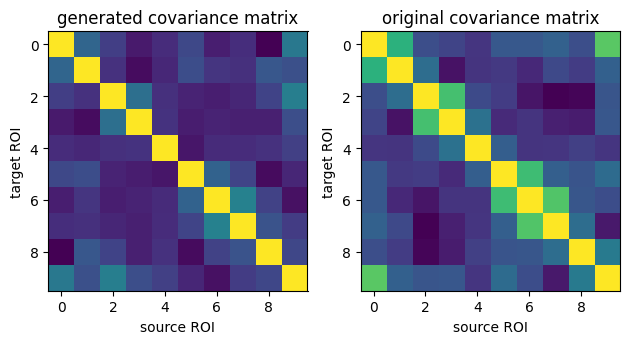

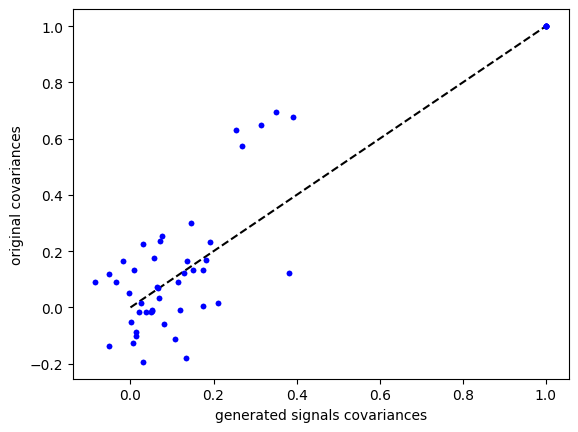

Covariance fit for covariances PearsonRResult(statistic=np.float64(0.8849208269403882), pvalue=np.float64(2.7247219794782787e-34))
Cohen's d using correlation 0.052147800642516784


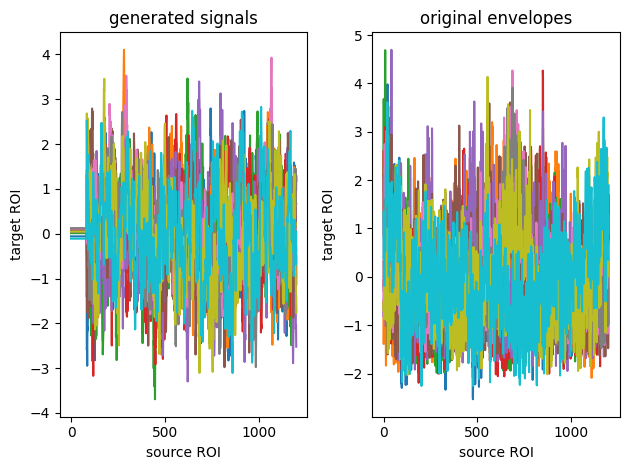

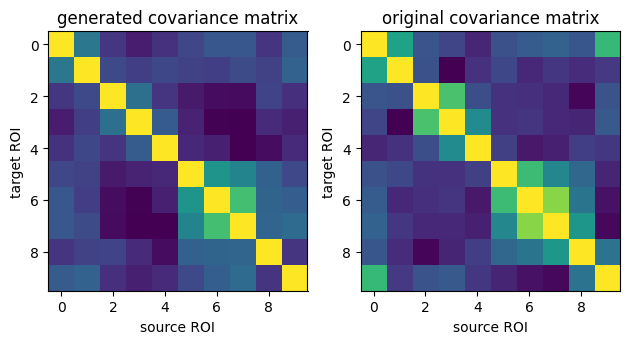

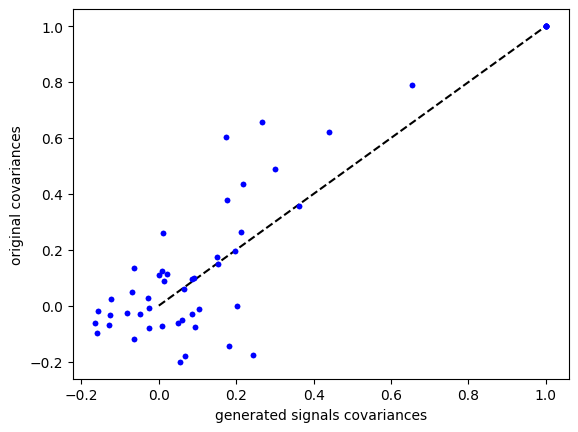

Covariance fit for covariances PearsonRResult(statistic=np.float64(0.8916024215018482), pvalue=np.float64(1.7161582843707177e-35))
Cohen's d using correlation 0.07506512130576563


In [18]:
# RESULTS FOR STATE 1 MODE WITH RANDOM INITIAL CONDITION

for motiv in range (2):
    mou_est_0 = mou_est_0_motiv[motiv]
    C_est_0 = c_est_0_motiv[motiv]
    mou_est_1 = mou_est_1_motiv[motiv]
    C_est_1 = c_est_1_motiv[motiv]

    ts_sim = ts_sim_motiv[motiv]
    ts_sim_0 = ts_sim_0_motiv[motiv]
    ts_sim_1 = ts_sim_1_motiv[motiv]

    ts_generated_rand_IC = mou_est_1.simulate(T=ts_sim.shape[0], dt=0.002)

    for i in range(ts_generated_rand_IC.shape[1]):
        ts_generated_rand_IC[:,i] = (ts_generated_rand_IC[:,i] - np.mean(ts_generated_rand_IC[:,i])) / np.std(ts_generated_rand_IC[:,i])

    fig, (ax_gen, ax_orig) = pp.subplots(1,2)
    ax_gen.plot(range(ts_generated_rand_IC.shape[0]),ts_generated_rand_IC)
    ax_gen.set_xlabel('source ROI')
    ax_gen.set_ylabel('target ROI')
    ax_gen.set_title('generated signals')

    ax_orig.plot(range(ts_sim.shape[0]),ts_sim_1)
    ax_orig.set_xlabel('source ROI')
    ax_orig.set_ylabel('target ROI')
    ax_orig.set_title('original envelopes')
    pp.tight_layout()

    pp.show()

    #Covariances of signals from simulate
    Q_generated_rand_IC = np.tensordot(ts_generated_rand_IC,ts_generated_rand_IC,axes=(0,0)) / (ts_generated_rand_IC.shape[0]-1)

    #Covariances of envelopes of original signals
    Q_th = np.tensordot(ts_sim_1,ts_sim_1,axes=(0,0)) / (ts_sim.shape[0]-1)

    # plots
    fig, (ax_gen, ax_orig) = pp.subplots(1,2)
    ax_gen.imshow(Q_generated_rand_IC)
    ax_gen.set_xlabel('source ROI')
    ax_gen.set_ylabel('target ROI')
    ax_gen.set_title('generated covariance matrix')

    ax_orig.imshow(Q_th)
    ax_orig.set_xlabel('source ROI')
    ax_orig.set_ylabel('target ROI')
    ax_orig.set_title('original covariance matrix')
    pp.tight_layout()

    pp.figure()
    pp.plot([0,Q_generated_rand_IC.max()],[0,Q_th.max()],'--k')
    pp.plot(Q_generated_rand_IC,Q_th,'.b')
    pp.xlabel('generated signals covariances')
    pp.ylabel('original covariances')

    pp.show()

    print('Covariance fit for covariances',stt.pearsonr(Q_th.flatten(),Q_generated_rand_IC.flatten()))
    print("Cohen's d using correlation", cohens_d(Q_th.flatten(),Q_generated_rand_IC.flatten()))

# CLASSIFIER

In [ ]:
def merge_blocks(ts, motivation):
    ts_tmp = ts.copy()
    #ts_tmp = np.swapaxes(ts,0,1)
    if motivation == 'SF':
        ts_sim = np.zeros((ts_tmp.shape[0],ts_tmp.shape[1], 4*ts_tmp.shape[2], 2), dtype='complex128')
        
        for i in range(2):
            start = i*2*ts_tmp.shape[2]
            ts_sim[:,:,start: start + 108,0] += ts_tmp[:, :, :, i*6]
            ts_sim[:,:,start + 108: start + 216,0] += ts_tmp[:, :, :, i*6 + 1]
            ts_sim[:,:,start: start + 108,1] += ts_tmp[:, :, :, i*6 + 2]/2
            ts_sim[:,:,start + 108: start + 216,1] += ts_tmp[:, :, :, i*6 + 3]/2
            ts_sim[:,:,start: start + 108,1] += ts_tmp[:, :, :, i*6 + 4]/2
            ts_sim[:,:,start + 108: start + 216,1] += ts_tmp[:, :, :, i*6 + 5]/2
    else:
        ts_sim = np.zeros((ts_tmp.shape[0], ts_tmp.shape[1], 4*ts_tmp.shape[2], 2), dtype='complex128')
        for i in range(2):
            start = i*2*ts_tmp.shape[2]
            ts_sim[:,:,start: start + 108,0] += ts_tmp[:, :, :, i*6 + 2]
            ts_sim[:,:,start + 108: start + 216,0] += ts_tmp[:, :, :, i*6 + 3]
            ts_sim[:,:,start: start + 108,1] += ts_tmp[:, :, :, i*6 + 4]
            ts_sim[:,:,start + 108: start + 216,1] += ts_tmp[:, :, :, i*6 + 5]
    
    return ts_sim

path = '../eeg/pacients_sans/EEG-BCN/'
file_name = 'dataClean-ICA3-'
ending = '-T1.mat'
subject_list = np.arange(25,36)
subject_number = 25

common_sources, average_signals = load_average(path, file_name, ending, subject_list)
sources, signals = load_single(path, file_name, ending, subject_number)

# FILTERING BY BAND

band = 'G' #G for gamma, B for betta
ts_sim = average_signals
ts_sim_subject = signals[np.where(common_sources)[0],:,:,:]
    
filtered = filtering(ts_sim, band)
filtered_subject = filtering(ts_sim_subject, band)

ts_sim_motiv = list()
ts_sim_motiv_subject = list()
for variable in variables:
    ts_sim_motiv.append(merge_blocks(ts_sim, variable))
    ts_sim_motiv_subject.append(merge_blocks(ts_sim_subject, variable))

Loading common sources and average signals...
Common sources and average signals loaded
Loading subject's sources and signals...
Subject's sources and signals loaded


In [ ]:
import sklearn.linear_model as skllm
import sklearn.neighbors as sklnn
import sklearn.discriminant_analysis as skda
import sklearn.preprocessing as skppc
import sklearn.pipeline as skppl
import sklearn.metrics as skm

# CLASSIFICACIÓ PER LA MITJANA DE SUBJECTES
for var, variable in enumerate(variables):
    # Get the time-series data for the current motivational state
    ts_data = ts_sim_motiv_subject[var].real
    ts_data = np.mean(ts_data,axis = 1)

    n_rep = 20
    perf = list()
    for i_rep in range(n_rep):
        # Initialize lists for train and test data
        ts_train = []
        ts_test = []
        labels_test = list()
        labels_train = list()

        for state in range(2):  # Iterate over the two motivational states (0 and 1)
            # Extract data for the current state
            ts_state = ts_data[:, :, state]  
            n_trials = ts_state.shape[1]

            
            # Randomly split indices into training (80%) and testing (20%) sets
            train_size = int(0.8 * n_trials)
            indices = np.arange(n_trials)
            np.random.shuffle(indices)
            train_indices = indices[:train_size]
            test_indices = indices[train_size:]
            
            
            # Append training and testing data for this state
            ts_train.append(ts_state[:, train_indices])
            ts_test.append(ts_state[:, test_indices])
            labels_train.extend([state] * len(train_indices))
            labels_test.extend([state] * len(test_indices))

        # Concatenate training and testing data across states
        ts_train_total = np.concatenate(ts_train, axis=1)
        ts_test_total = np.concatenate(ts_test, axis=1)

        ts_train_total = ts_train_total.T  # Shape: (690, 10)
        ts_test_total = ts_test_total.T  # Shape: (690, 10)

        # Classifier and learning parameters
        c_MLR = skppl.make_pipeline( skppc.StandardScaler(), 
                                    skllm.LogisticRegression(C=0.1, 
                                                            penalty='l2', 
                                                            solver='lbfgs', 
                                                            max_iter=500) )
        # Train and test classifiers with subject labels
        c_MLR.fit(ts_train_total, labels_train)
        perf.append(c_MLR.score(ts_train_total,labels_train))

    print(perf)



    
  
    

(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
[0.5376811594202898, 0.5463768115942029, 0.5376811594202898, 0.5304347826086957, 0.5304347826086957, 0.5376811594202898, 0.5347826086956522, 0.527536231884058, 0.5420289855072464, 0.5231884057971015, 0.5434782608695652, 0.553623188405797, 0.5347826086956522, 0.5318840579710145, 0.5594202898550724, 0.527536231884058, 0.5289855072463768, 0.5347826086956522, 0.5391304347826087, 0.5463768115942029]
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
(690, 10)
[0.553623188405797, 0.5797101449275363, 0.5782608695652174, 0.5855072463768116, 0.5594202898550724, 0.5869565217391305, 0.5478260869565217, 0.5565217391304348, 0.5579710144927537, 0.5434782608695652, 0.

In [ ]:
# CLASSIFICACIÓ PEL SUBJECTE 25

# Miscellaneous calculations and drafts

In [1]:
for motiv in range (2):
    ts_sim_0 = ts_sim_0_motiv[motiv]

    n_T = np.shape(ts_sim_0)[0]
    n_nodes = np.shape(ts_sim_0)[1]
    n_tau = 200

    Q_emp = np.zeros([n_tau, n_nodes, n_nodes], dtype=float)

    # Calculate the lagged FC matrices
    n_T_span = n_T - n_tau + 1
    for i_tau in range(n_tau):
        Q_emp[i_tau] = np.tensordot(ts_sim_0[0:n_T_span],
                                    ts_sim_0[i_tau:n_T_span+i_tau],
                                    axes=(0,0)) / float(n_T_span - 1)

    ac = Q_emp.diagonal(axis1=1,axis2=2)

    pp.figure()
    pp.plot(range(n_tau), ac[:,:])
    pp.axis(ymin=0)
    pp.xlabel('time lag', fontsize=14)
    pp.ylabel('autocovariance', fontsize=14)

    pp.figure()
    pp.plot(range(n_tau), np.log(np.maximum(ac[:,:],1e-4)))
    pp.xlabel('time lag', fontsize=14)
    pp.ylabel('log autocovariance', fontsize=14)

    pp.show()

NameError: name 'ts_sim_0_motiv' is not defined

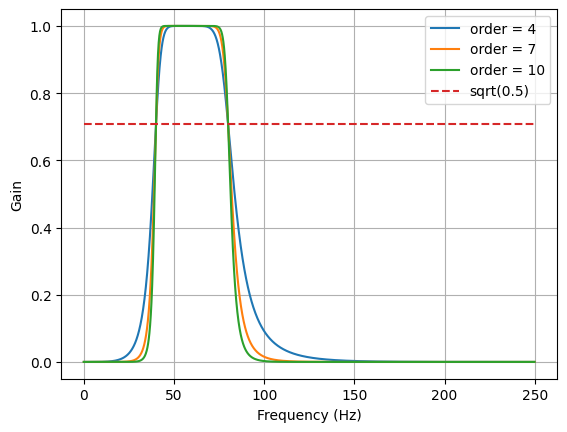

In [12]:
from scipy.signal import butter, lfilter
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

# Sample rate and desired cutoff frequencies (in Hz).
fs = 500.0
lowcut = 40.0
highcut = 80.0

# Plot the frequency response for a few different orders.
pp.figure(1)
pp.clf()
for order in [4, 7, 10]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, fs=fs, worN=2000)
    plt.plot(w, abs(h), label="order = %d" % order)

pp.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
pp.xlabel('Frequency (Hz)')
pp.ylabel('Gain')
pp.grid(True)
pp.legend(loc='best')